# Hands On Instrument Data Selection and Binning

This notebook teaches how to deal with DL3 data from current IACTs and other HE or VHE instruments. The Data Level 3 (DL3) format is described here 

Please refer to [this notebook](https://github.com/arqus-gamma/arqus_school_2022/blob/main/hands_on/1_read_data/Read_data_with_astropy_hands_on.ipynb) for preliminary introduction

The Cherenkov Telescope Array (CTA) is the next generation ground-based observatory for gamma-ray astronomy. Gammapy is the core library for the Cherenkov Telescope Array (CTA) science tools (2017ICRC…35..766D and CTAO Press Release).

Tutorial overview
This notebook shows how to access CTA data and instrument response functions (IRFs) using Gammapy, and gives some examples how to quick look the content of CTA files, especially to see the shape of CTA IRFs.

At the end of the notebooks, we give several links to other tutorial notebooks that show how to simulate CTA data and how to evaluate CTA observability and sensitivity, or how to analyse CTA data.

Note that the FITS data and IRF format currently used by CTA is the one documented at https://gamma-astro-data-formats.readthedocs.io/, and is also used by H.E.S.S. and other imaging atmospheric Cherenkov telescopes (IACTs). So if you see other Gammapy tutorials using e.g. H.E.S.S. example data, know that they also apply to CTA, all you have to do is to change the loaded data or IRFs to CTA.



## Table of contents
- [Initial Setup](#Initial-Setup)
- [Data Access](#Data-Access)
- [Sky Distribution](#Sky-Distribution)
- [Gammaness](#Gammaness)

Energy Distribution
Effective Area HDU

Definition of the Signal Search Region
Theta2 Plot
Final Considerations

## Initial Setup
- [Go back to TOC](#Table-of-contents)

As usual, we start by installing some standards packages. We try to be minimal and install only those stricly required.
Check package versions. All examples should work with Astropy > 2.0 and Numpy > 1.11

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

import glob as glob # required for file handling

In [2]:
import numpy as np

import astropy
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.23.2
astropy: 5.1


In [3]:
import regions
from regions import CircleSkyRegion, PointSkyRegion

print('regions:', regions.__version__)

regions: 0.6


Now we import some relevant gammapy classes and modules

In [4]:
import gammapy

# gammapy classes
from gammapy.data import Observation, Observations, DataStore, EventList
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder

import gammapy.irf as irf
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs

from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom



# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

print("gammapy:", gammapy.__version__)

gammapy: 0.20


We now go back again to importing data. This time, there will be general methods for importing multiple files. There is an issue on the data of back-compatibility with the software (Crab data are older). We will have to make some manual adjustments sometimes

## Data Access
- [Go back to TOC](#Table-of-contents)

In [9]:
!ls ../../data/

README.md          crab_nebula        ic310              ngc1275
arqus_filelist.txt download_data.sh   mrk421             pks2155


In [10]:
#!ls ../../data/crab_nebula/magic
#!ls ../../data/pks2155/hess/
#!ls ../../data/ic310/magic
!ls ../../data/ngc1275/magic

20170101_05059487_DL3_NGC1275-W0.40+157.fits
20170101_05059488_DL3_NGC1275-W0.40+337.fits
20170101_05059489_DL3_NGC1275-W0.40+058.fits
20170101_05059490_DL3_NGC1275-W0.40+238.fits
20170101_05059497_DL3_NGC1275-W0.40+238.fits
20170101_05059498_DL3_NGC1275-W0.40+157.fits
20170101_05059499_DL3_NGC1275-W0.40+337.fits
20170101_05059500_DL3_NGC1275-W0.40+337.fits
hdu-index.fits.gz
obs-index.fits.gz


We now generate an object specific of `gammapy` that generate an `observation` object and fill it with all the files

In [39]:
observations = Observations()
#for filename in glob.glob(f"../../data/ngc1275/magic/*fits"):
for filename in glob.glob(f"../../data/mrk421/magic/*fits"):
    observations.append(Observation.read(filename))

We can check the observations 'ids'

In [40]:
observations.ids

['5093624',
 '5095324',
 '5094413',
 '5095321',
 '5096810',
 '5094412',
 '5093621',
 '5097458',
 '5097457',
 '5094548',
 '5096812',
 '5096932',
 '5096213',
 '5094547',
 '5096214',
 '5093620',
 '5096811',
 '5096935',
 '5096934',
 '5096071',
 '5093625',
 '5096933',
 '5094411',
 '5095322',
 '5093622',
 '5096212',
 '5096072',
 '5093623',
 '5095323']

However, not much more is available for all observations. If one wants to check what's in a single run, this can be accssed by 

In [41]:
obs = observations[1]

obs.tstart

obs.gti.table
obs.gti.time_stop
obs.gti.time_delta

obs.fixed_pointing_info.meta
obs.fixed_pointing_info.altaz

obs.obs_info.keys()

#obs.aeff.peek()
#obs.events.peek()

odict_keys(['EXTNAME', 'HDUCLASS', 'HDUDOC', 'HDUVERS', 'HDUCLAS1', 'OBS_ID', 'TSTART', 'TSTOP', 'ONTIME', 'LIVETIME', 'DEADC', 'OBS_MODE', 'EQUINOX', 'RADECSYS', 'ORIGIN', 'TELESCOP', 'INSTRUME', 'CREATOR', 'VERSION', 'MJDREFI', 'MJDREFF', 'TIMEUNIT', 'TIMESYS', 'TIMEREF', 'OBJECT', 'RA_OBJ', 'DEC_OBJ', 'RA_PNT', 'DEC_PNT', 'ALT_PNT', 'AZ_PNT'])

In [42]:
import warnings
warnings.filterwarnings('ignore')

i = 0
for obs in observations:
    if i == 0:
        events = obs.events
    else:
        events.stack( obs.events)
    i +=1

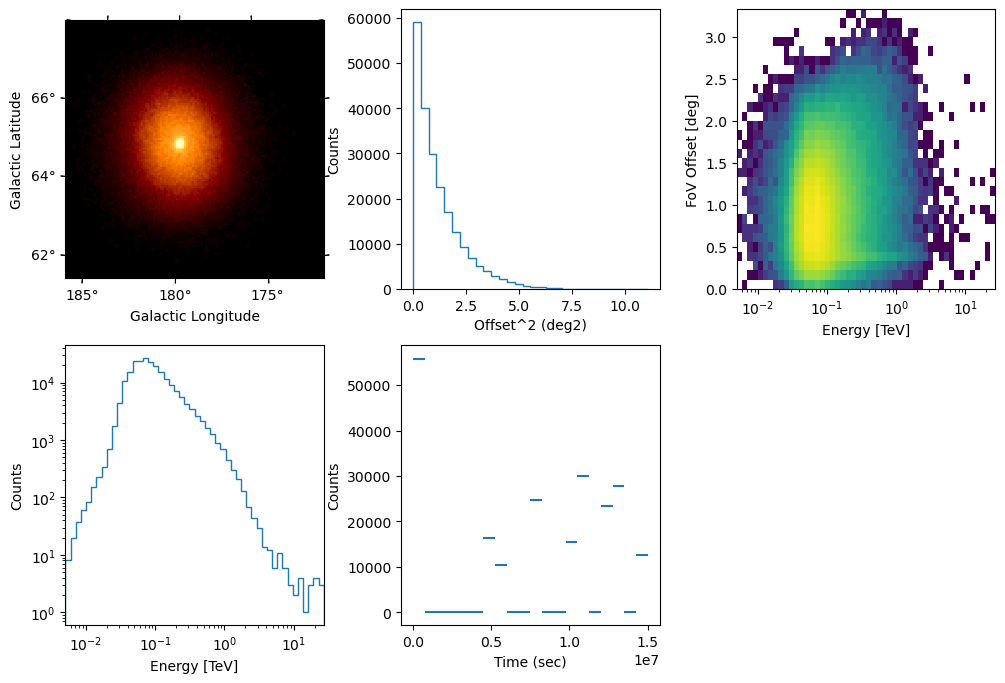

In [43]:
events.peek()

In [70]:
en  = events.energy.to('TeV')
t   = events.time
ra  = events.radec.ra
dec = events.radec.dec
g   = events.table['GAMMANESS']


<Quantity [0.09739587, 0.23275723, 0.09401752, ..., 0.09089286, 0.2734905 ,
           0.10595912] TeV>

## Sky Distribution
[back to top](#Table-of-contents)

We know see how events directions appear in a map

In [66]:
ra_pnt = events.pointing_radec.ra 
dec_pnt = events.pointing_radec.dec

source_pos   =  SkyCoord.from_name('Mrk421')

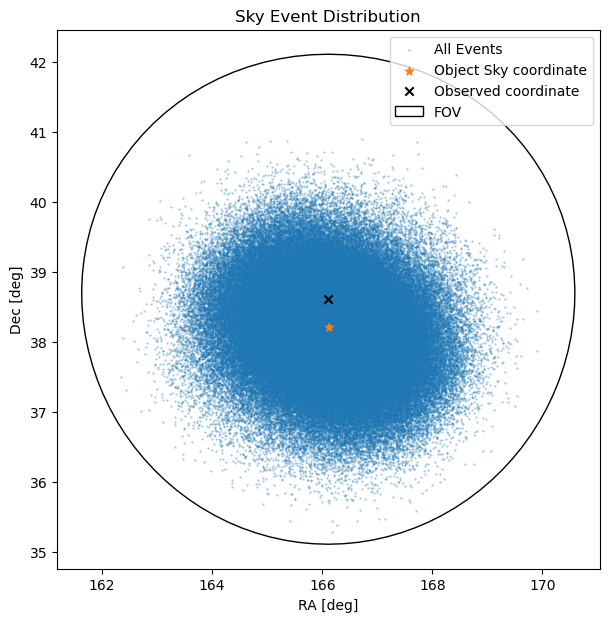

In [58]:
# Direction of the events
fig, ax =  plt.subplots(figsize=(7,7))
#ax = plt.subplot(projection=wcs)

ax.scatter(ra,dec, s=0.2, alpha=0.5, label="All Events")
ax.scatter(source_pos.ra, source_pos.dec, marker="*", label="Object Sky coordinate")
ax.scatter(ra_pnt,dec_pnt, marker="x", color = 'black', label="Observed coordinate")


fov = SphericalCircle( (ra_point, dec_point),
                    3.5 * u.deg,   edgecolor='black', facecolor='none', label="FOV")
ax.add_patch(fov)


plt.ylabel('Dec [deg]')
plt.xlabel('RA [deg]')
plt.title('Sky Event Distribution')
ax.legend(loc="best")

## Event Energy Distribution
-[Go back to TOC](#Table-of-contents)

Let's look at how the energy of the data is distributed

UnitConversionError: '' (dimensionless) and 'TeV' (energy/torque/work) are not convertible

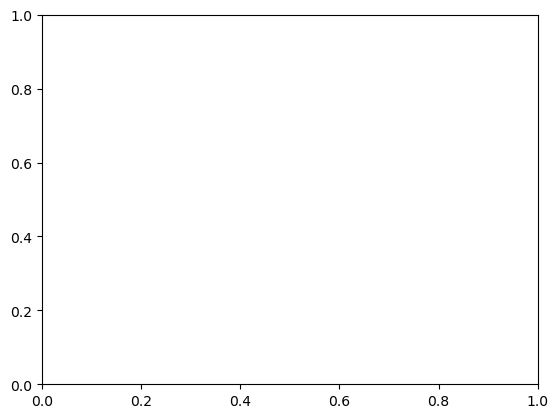

In [73]:
# The binning should be defined first
binning = np.logspace(-2,1,20)

plt.hist(en,bins=binning,alpha=0.6,log=True)
plt.xscale('log')

plt.xlabel('Energy [TeV]')
plt.ylabel('Counts')
plt.title('Energy distribution')

## Gammaness
[Go back to TOC](#Table-of-contents)

Text(0, 0.5, 'Counts')

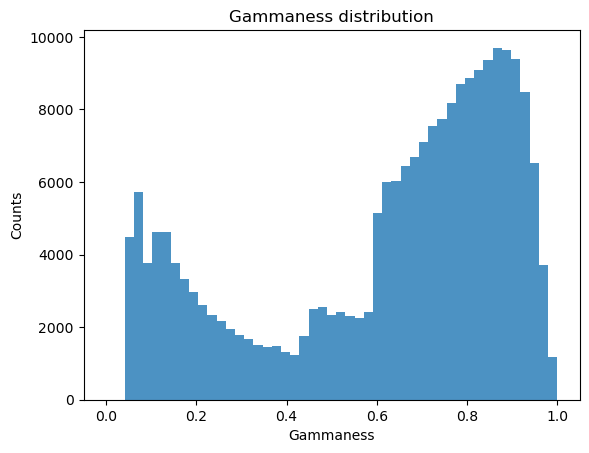

In [74]:
binning = np.linspace(0,1,50)
plt.hist(g,bins=binning,alpha=0.8)

plt.title('Gammaness distribution')
plt.xlabel('Gammaness')
plt.ylabel('Counts')